In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from scipy.linalg import null_space
from collections import Counter, defaultdict

In [2]:
N_PLAYERS = 3
ACTIONS = [1, -1]
N_ACTIONS = len(ACTIONS)
N_STEPS = 100
N_SIMULATIONS = 10000
BURN_IN = 10

n_states_tuple = tuple(N_ACTIONS for _ in range(N_PLAYERS))
n_config = N_ACTIONS ** N_PLAYERS
BETA = 6.0

In [ ]:
def get_utility(player_idx, config_tuple, n1):
    u = 0
    is_coordinator = player_idx < n1
    
    for j in range(N_PLAYERS):
        if j == player_idx: continue
        
        if is_coordinator:
            val = 0.5 * abs(config_tuple[player_idx] + config_tuple[j])
        else:
            val = 0.5 * abs(config_tuple[player_idx] - config_tuple[j])
        u += val
    return u


def build_Lambda(n1):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple) # Converts numeric index in a tuple of indices
        x_indices = np.array(x_indices)
        
        # Mapping indices -> real values
        current_config = [ACTIONS[k] for k in x_indices]
        
        for player in range(N_PLAYERS):
            utilities = []
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities.append(get_utility(player, y_config, n1))
            
            # Best Response Set
            max_u = max(utilities)
            br_indices = [idx for idx, u in enumerate(utilities) if u == max_u]
            
            # Compute choice probability
            prob_choice = 1.0 / len(br_indices)
            
            for action_idx in br_indices:
                if action_idx == x_indices[player]:
                    continue
                
                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)
                
                Lambda[x_id, y_id] += 1.0 * prob_choice

    return Lambda


# using the 2nd approach of CTMC
def simulation(Lambda, start_id, N_STEPS=100):    
    Lambda_dense = Lambda.toarray()
    n_states = Lambda_dense.shape[0]

    w = np.sum(Lambda_dense, axis=1)


    for i in range(n_states):
        if w[i] == 0: # absorbing state, no changes
            w[i] = 1.0
            Lambda_dense[i, i] = 1.0

    P = Lambda_dense / w[:, None]


    states = np.zeros(N_STEPS, dtype=int)
    transition_times = np.zeros(N_STEPS)
    
    states[0] = start_id
    current_id = start_id
    current_time = 0.0

    # simulation cycle
    for i in range(1, N_STEPS):
        t_next = -np.log(np.random.rand()) / w[current_id]
        
        current_time += t_next
        transition_times[i] = current_time

        probs = P[current_id, :]
        next_id = np.random.choice(n_states, p=probs)
        states[i] = next_id
        current_id = next_id

    return transition_times, states


# for a better visualization
def get_label(x_id):
        idx = np.unravel_index(x_id, n_states_tuple)
        return "".join(["+" if ACTIONS[k]==1 else "-" for k in idx])


In [ ]:
def solver(n1, title_suffix):
    print(f"{title_suffix} (n1={n1})")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)

    Lambda = build_Lambda(n1)

    # transition graph
    G = nx.DiGraph()
    cx = Lambda.tocoo() # convert to Coordinate format for easy iteration
    for i, j, v in zip(cx.row, cx.col, cx.data):
        G.add_edge(get_label(i), get_label(j), weight=v)


    # Compute stationary distribution
    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue # Skip the initial transition
                
            state = traj[k]
            duration = times[k+1] - times[k]
            
            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]
    
    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"  State {lbl}: {prob:.4f}")


    # Simulation for plotting
    times, traj = simulation(Lambda, start_id, N_STEPS)
    

    # Plot simulation
    plt.figure(figsize=(10, 4))
    plt.step(times, traj, where='post', color='blue', marker='o', markersize=4, linewidth=1.5)
    plt.yticks(range(n_config), [get_label(i) for i in range(n_config)])
    plt.title(f"Traiettoria (Sparse Matrix)\n{title_suffix}")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.show()
    

    # Plot transition graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42, k=1.5)
    nx.draw_networkx(G, pos, node_color='lightgray', node_size=1500, edgecolors='black')
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray')
    
    nx.draw_networkx_edge_labels(
        G, pos, 
        edge_labels=edge_labels, 
        font_size=8, 
        label_pos=0.6,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
    plt.axis('off')
    plt.title(f"Transition Graph\n{title_suffix}")
    plt.show()

Coordinamento Puro (n1=3)

Risultati dettagliati:
  Stato +++: 0.6604
  Stato ---: 0.3396


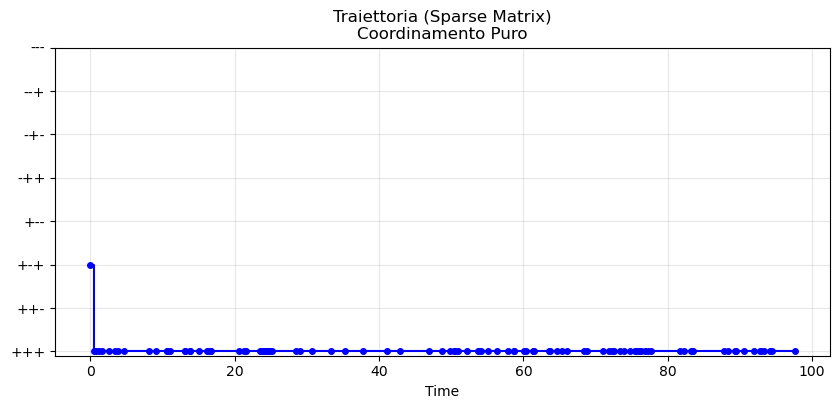

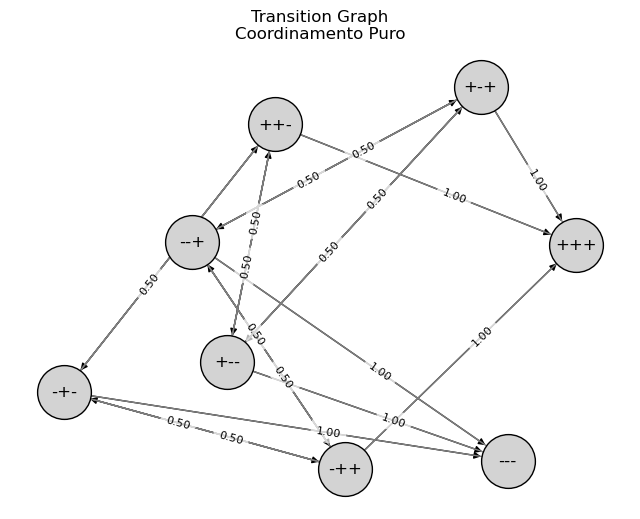

In [ ]:
# --- ESECUZIONE ---
solver(3, "Pure cooridination")

Anti-Coordinamento (n1=0)

Risultati dettagliati:
  Stato ++-: 0.1685
  Stato +-+: 0.1677
  Stato +--: 0.1647
  Stato -++: 0.1686
  Stato -+-: 0.1661
  Stato --+: 0.1645


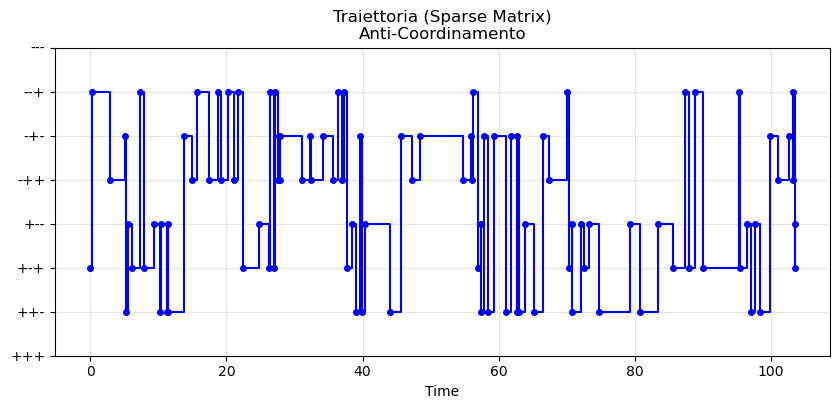

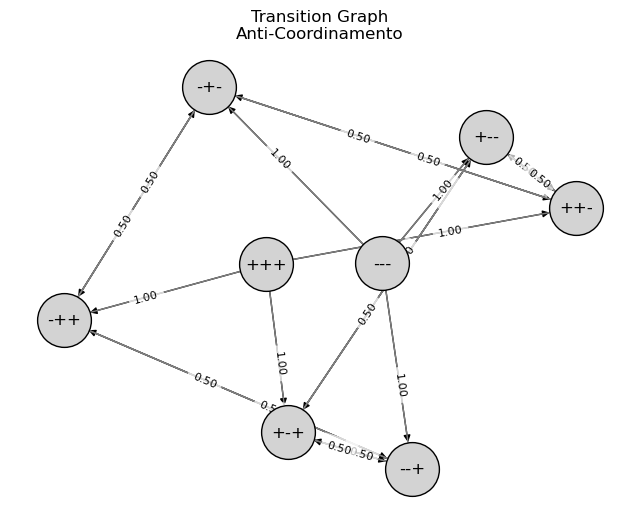

In [ ]:
solver(0, "Anti-Coordination")

n1 = 3  
Calcolo delle Probabilità Limite:
Sia $p$ la probabilità di convergere a $S_{All+}$ partendo da $S_0$.  
Con probabilità $\frac{1}{2}$ va a $S_{All+}$ (assorbente).  
Con probabilità $\frac{1}{2}$ va a $S_{mix-}$.  

Sia $q$ la probabilità di convergere a $S_{All+}$ partendo da $S_{mix-}$.  
Con probabilità $\frac{1}{2}$ va a $S_{All-}$ (assorbente, quindi prob di andare a All+ è 0).  
Con probabilità $\frac{1}{2}$ torna a $S_0$.  
Il sistema di equazioni è:
$$p = \frac{1}{2}(1) + \frac{1}{2}q$$
$$q = \frac{1}{2}(0) + \frac{1}{2}p$$
Sostituendo la seconda nella prima:
$$p = \frac{1}{2} + \frac{1}{2}(\frac{1}{2}p) = \frac{1}{2} + \frac{1}{4}p$$
$$\frac{3}{4}p = \frac{1}{2} \implies p = \frac{2}{3}$$
Per simmetria, la probabilità di finire in $S_{All-}$ è $1 - p = 1/3$.Risultato (b1):$$\lim_{t \to +\infty} \mathbb{P}(X(t)=x|X(0)=(+1,-1,+1)) = \begin{cases} 2/3 & \text{se } x = (+1, +1, +1) \\ 1/3 & \text{se } x = (-1, -1, -1) \\ 0 & \text{altrimenti} \end{cases}$$  

n1 = 0  
Il sistema è confinato in questo insieme chiuso di 6 stati e la dinamica è simmetrica (ogni transizione ha lo stesso rate), la distribuzione stazionaria è uniforme su questi stati.  
Risultato: il limite della distribuzione è $1/6$ per ciascuna delle 6 configurazioni non di consenso, e 0 per le due configurazioni di consenso.
$$\lim_{t \to +\infty} \mathbb{P}(X(t)=x|X(0)=(+1,-1,+1)) = \begin{cases} 1/6 & \text{se } x \in \text{Stati Bilanciati (non tutti uguali)} \\ 0 & \text{se } x \in \{(+,+,+), (-,-,-)\} \end{cases}$$

#### Noisy Dynamics Best Response
with $\beta \to \infty$ (vanishing noise)

In [ ]:
# List of all states
ALL_STATES = list(itertools.product(ACTIONS, repeat=N_PLAYERS))

def build_Lambda_noisy(n1, beta):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        x_indices = np.array(x_indices)
        
        current_config = [ACTIONS[i] for i in x_indices]
        
        for player in range(N_PLAYERS):
            utilities = np.zeros(N_ACTIONS)
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities[action_idx] = get_utility(player, y_config, n1)
            
            # exp(beta * U)
            exp_utilities = np.exp(beta * utilities)
            sum_exp = np.sum(exp_utilities)
            
            for action_idx, action_val in enumerate(ACTIONS):
                if action_idx == x_indices[player]:
                    continue

                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)
                
                Lambda[x_id, y_id] += exp_utilities[action_idx] / sum_exp

    return Lambda


def solver_noisy(n1, case_name):
    print(f"\n--- {case_name} ---")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)
    
    Lambda = build_Lambda_noisy(n1, BETA)
    
    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue
                
            state = traj[k]
            duration = times[k+1] - times[k]
            
            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]
    
    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"State {lbl}: {prob:.4f}")
    

In [79]:
# Eseguiamo per i due casi
solver_noisy(3, "Caso (b1): Coordinamento Puro (n1=3)")


--- Caso (b1): Coordinamento Puro (n1=3) ---

Risultati dettagliati:
  Stato +++: 0.4942
  Stato ---: 0.5058


In [80]:
solver_noisy(0, "Caso (b4): Anti-Coordinamento Puro (n1=0)")


--- Caso (b4): Anti-Coordinamento Puro (n1=0) ---

Risultati dettagliati:
  Stato ++-: 0.1698
  Stato +-+: 0.1688
  Stato +--: 0.1651
  Stato -++: 0.1673
  Stato -+-: 0.1658
  Stato --+: 0.1633


##### with theory 
using
$$\lim_{\beta \to \infty}\lim_{t \to \infty} P(X(t)=x) = \lim_{\beta \to \infty} \pi_x =
\begin{cases}
   \frac{1}{|\argmax \Phi|} &\text{if } x\in \argmax \Phi\\
   0 &\text{otherwise}
\end{cases}$$

In [51]:
def get_potential_and_states(n1):
    states_data = []
    
    # all possible states
    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        config = [ACTIONS[k] for k in x_indices]
        
        total_utility = sum(get_utility(i, config, n1) for i in range(N_PLAYERS))
        
        potential = 0.5 * total_utility # because each link is counted twice
        
        label = "".join(["+" if c==1 else "-" for c in config])
        states_data.append({'id': x_id, 'label': label, 'potential': potential})
        
    return states_data


def verify_theoretical_limit(n1):
    states_data = get_potential_and_states(n1)
    
    max_pot = max(s['potential'] for s in states_data)
    
    max_states = [s for s in states_data if np.isclose(s['potential'], max_pot)]
    
    prob_theoretical = 1.0 / len(max_states)
    
    print(f"Max potential: {max_pot}")
    print(f"State at max potential: {len(max_states)}")
    print(f"Theoretical probability: {prob_theoretical:.4f} on")
    for s in max_states:
        print(f"   * {s['label']}")

In [ ]:
verify_theoretical_limit(3)

Max potential: 3.0
State at max potential: 2
Theoretical probability: 0.5000 on
   * +++
   * ---


In [ ]:
verify_theoretical_limit(0)

Max potential: 2.0
State at max potential: 6
Theoretical probability: 0.1667 on
   * ++-
   * +-+
   * +--
   * -++
   * -+-
   * --+
